# Part 1 - Exploratory data analysis
The    attached       logins.json       file     contains     (simulated)     timestamps    of    user     logins     in    a    particular  geographic     location.     Aggregate     these     login     counts    based    on    15­ minute     time     intervals,    and  visualize     and    describe     the     resulting     time     series    of     login     counts     in    ways     that    best     characterize     the  underlying    patterns     of     the    demand.     Please     report/illustrate     important     features    of     the    demand,  such     as    daily     cycles.     If     there     are     data     quality     issues,    please     report     them. 


In [468]:
# First step is to import JSON data into a Pandas Dataframe

# Import pandas library
import pandas as pd

# Read data from json file
df = pd.read_json("logins.json", orient="records")

# Check th data type of the column Login_time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [408]:
# Check maximum and minimum dates to set the bins

print(min(df.login_time), max(df.login_time))

1970-01-01 20:12:16 1970-04-13 18:57:38


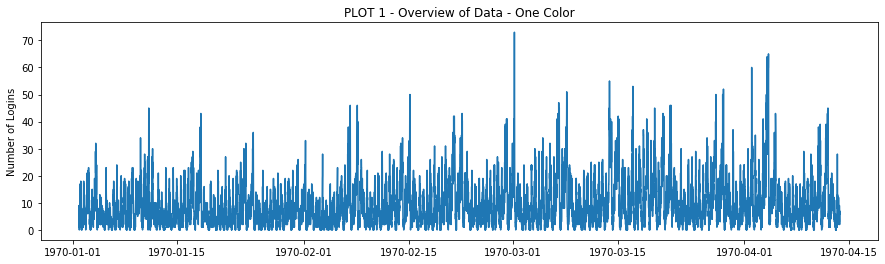

In [409]:
# Data imported as datetime64
# Now let's create bins for login times, make a column for the bins and group by the bins

# Create bins for every 15 minutes
bins = pd.date_range('1970-01-01 20:00:00', '1970-04-13 19:00:00', freq='15min')

# Create a column with the corresponding bin
df['Bin'] = pd.cut(df.login_time, bins)

# Grab just the lower bound of the interval
df['Bin'] = df['Bin'].apply(lambda x:x.left)

# Group by the Bin column
df_bin = df.groupby("Bin", as_index=False).count()

# Let's see how the number of logins varies through time
plt.plot(df_bin.Bin, df_bin.login_time)

plt.rcParams["figure.figsize"] = (12,4)
plt.title("PLOT 1 - Overview of Data - One Color")
plt.ylabel("Number of Logins")

plt.show()

## PLOT 1 Analysis
The data presents spikes. Let's investigate weekly patterns by coloring the weekends.
Besides, the number of connections seems to increase over time. Let's see if we can confirm this trend by analyzing the data by Month, Week and Day

In [410]:
# Create colums for Month, Day and day of the week (DOW)
df_bin['Month'] = df_bin['Bin'].apply(lambda x:x.month)
df_bin['Day'] = df_bin['Bin'].apply(lambda x:x.day)
df_bin['DOW'] = df_bin['Bin'].apply(lambda x:x.weekday())
df_bin['Hour'] = df_bin['Bin'].apply(lambda x:x.time)

# Different colors for weekends
# Friday = yellow, Saturday = red, Sunday = Green, others = blue
df_bin['Color'] = df_bin['DOW'].apply(lambda x : 'yellow' if x == 4 else ('red' if x == 5 else ('green' if x== 6 else 'blue')))

# Rename column
df_bin.columns = ['Bin','Login_count', 'Month', 'Day', 'DOW', 'Hour', 'Color']

# Check df_bin
df_bin

,Bin,Login_count,Month,Day,DOW,Hour,Color
0,1970-01-01 20:00:00,2,1,1,3,20:00:00,blue
1,1970-01-01 20:15:00,6,1,1,3,20:15:00,blue
2,1970-01-01 20:30:00,9,1,1,3,20:30:00,blue
3,1970-01-01 20:45:00,7,1,1,3,20:45:00,blue
4,1970-01-01 21:00:00,1,1,1,3,21:00:00,blue
...,...,...,...,...,...,...,...
9783,1970-04-13 17:45:00,5,4,13,0,17:45:00,blue
9784,1970-04-13 18:00:00,5,4,13,0,18:00:00,blue
9785,1970-04-13 18:15:00,2,4,13,0,18:15:00,blue
9786,1970-04-13 18:30:00,7,4,13,0,18:30:00,blue


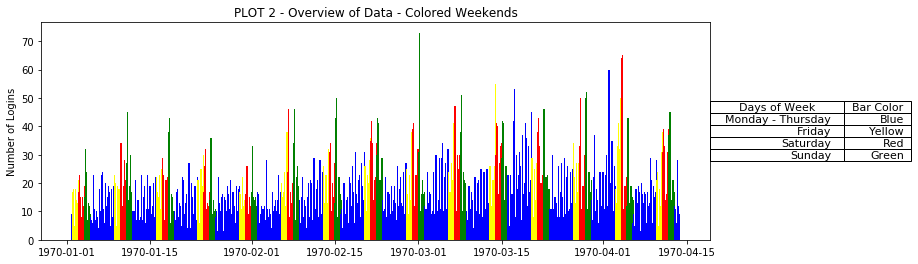

In [411]:
# Plot the whole series with different colors for weekends
plt.bar(df_bin.Bin, df_bin.Login_count, color=list(df_bin.Color), width=0.2)
plt.rcParams["figure.figsize"] = (15,4)
plt.title("PLOT 2 - Overview of Data - Colored Weekends")

# Plot table with color code
the_table = plt.table(cellText=list(zip(["Monday - Thursday", "Friday", "Saturday", "Sunday"],["Blue", "Yellow", "Red", "Green"])),
                      colLabels=["Days of Week", "Bar Color"],
                      loc = 'right',
                      colWidths = [0.2,0.1])
the_table.auto_set_font_size(False)
the_table.set_fontsize(11)

plt.ylabel("Number of Logins")
plt.show()


## PLOT 2 Analysis
- At first glance, it seems evident that Saturdays and Sundays are the days of the week that presents more spikes. We can spot several "Green peaks" through the weeks, especially until February. Does that mean that Sundays are busier than Saturdays on average? <b>This may be confirmed by PLOT 3 - Monthly Average</b>
- The third week of March (starting 1970-03-15) and the first week of April (starting 1970-04-01) presents unusual behaviors with spikes during weekdays. What could be behind this? Holiday? March break? I wouldn't bet on a "permanent" increase on demand, like moving to a higher plateau, because we don't see this behavior for the weeks starting in 1970-03-22 or 1970-04-08. <b>This may be confirmed by PLOT 4 - Weekly Average</b>

C:\Users\Rafael\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


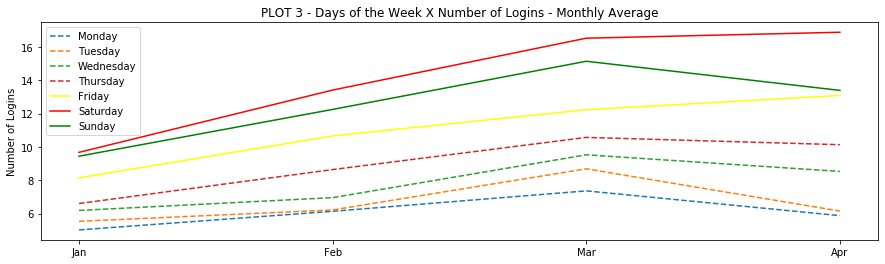

In [412]:
# Import needed library
import numpy as np

# list of lists to record y coordinate ("height"), one list for each Month, each list with 7 records, one for each D.O.W.
h = []

# Loop though months 1 to 4
for m in np.arange(1,5,1):
    # Dummy list to record the seven login_count averages, one for each D.O.W
    aux = []
    # Loop throuh the seven D.O.W
    for d in range(7):   
        # Append the mean for the seven D.O.W for month m
        aux.append(df_bin[df_bin.Month==m][df_bin.DOW == d]["Login_count"].mean())
    # Append dummy list to main list h    
    h.append(aux)

# Loop through D.O.W.
for (i,v) in enumerate(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]):
    # Dummy list to record
    aux = []
    # For a given D.O.W., grab the 4 points from h and append to aux
    for j in range(4):
        aux.append(h[j][i])
    
    # For color consistency, weekends have the same color (yellor, red and green, respectively).
    # Labels are taken from the enumarated list
    # Weekdays have dashed line, to be easily distinguished from weekends.
    # Xticks for x axis
    xticks = ["Jan", "Feb", "Mar", "Apr"]
    if(i<4):
        # Monday to Thursday
        plt.plot(xticks,aux, label = v, linestyle='dashed')
    elif(i==4):
        # Friday
        plt.plot(xticks,aux, label = v, color='yellow')
    elif(i==5):
        # Saturday
        plt.plot(xticks,aux, label = v, color='red') 
    else:
        # Sunday
        plt.plot(xticks,aux, label = v, color='green')     

    
plt.legend()
plt.title("PLOT 3 - Days of the Week X Number of Logins - Monthly Average")
plt.ylabel("Number of Logins")
plt.show()    
    

## PLOT 3 Analysis
- <b>Saturdays are consistently the busiest days through the months</b>, even though PLOT 2 shows all those Spikes on Sundays. This can be further analyzed by <b>PLOT 5 - Daily averages.</b> 
- This plot is almost too perfect because we can easily confirm that:
  - <b>the overall demand for Ultimate services are increasing over time, on average </b>
  - The demand is at its lowest on Monday and it slowly increases as the days progress into the Weekend, reaching its peak on Saturday. <b>My initial intuition was wrong: weekdays (Monday to Thursday) are distinguishable, as far as the demand is concerned.</b>
<br>
Let's get to PLOT 4, with weekly averages, to see if we can confirm that there is a significant increase in demand after the week of 1970-03-15, or if it's just an outlier.

C:\Users\Rafael\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Rafael\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


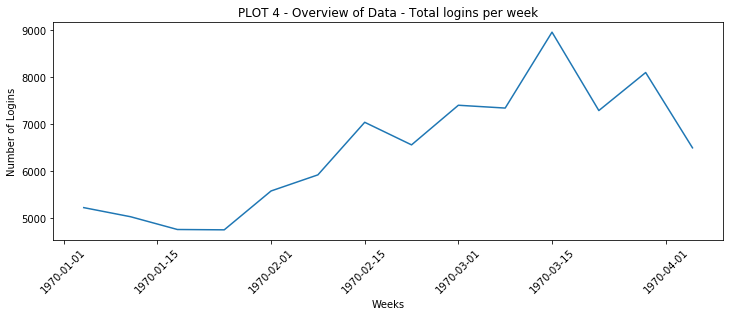

In [465]:
# Plot 4
bins_week = pd.date_range('1970-01-01', '1970-04-13', freq='W')

df_aux = df_bin[["Bin", "Login_count"]]

df_aux.loc[:,'Date'] = df_aux.loc[:,'Bin'].apply(lambda x:x.date)
df_aux.loc[:,'Date'] = df_aux.loc[:,'Date'].apply(lambda x:pd.Timestamp(x))

# Create a column with the corresponding bin
df_aux.loc[:,'Bin_week'] = pd.cut(df_aux.Date, bins_week)

# Grab just the lower bound of the interval
df_aux.loc[:,'Bin_week'] = df_aux.loc[:,'Bin_week'].apply(lambda x:x.left)

# Drop useless columns
df_aux = df_aux.drop(labels=["Bin", "Date"], axis=1)


# Group by the Bin_week column
df_aux = df_aux.groupby("Bin_week", as_index=False).sum()

# Let's see how the number of logins varies through time
plt.plot(df_aux.Bin_week, df_aux.Login_count)

plt.rcParams["figure.figsize"] = (12,4)
plt.title("PLOT 4 - Overview of Data - Total logins per week")
plt.ylabel("Number of Logins")
plt.xlabel("Weeks")
plt.xticks(rotation=45)
plt.show()

## PLOT 4 Analysis
- This plot makes it easy for us to identify a "jump" on the number of logins that happens from week 01-15 to week 02-15.
- It is not clear that another plateau is reached after week 03-15. We would need more data to confirm that.
- With the amount of data we have, week 03-15 does look like an outlier. It would be interesting to investigate what's behind this behavior so that special rates for drivers could be proposed on similar situations in the future
- The general upwards trend is confirmed, ultimate is a success!
<br><br>
Lastly, let's see if we can identify any daily patterns for all days of the week. To do so, I'll calculate the average (using all data) for each 15 minutes bin using DataFrame.groupby. A function will be handy.

In [386]:
# Function to define plotting parameters for the D.O.W
def toPlot(dow):
    df = df_bin[df_bin.DOW==dow]
    df = df.groupby(by=["DOW", "Hour"], as_index=False).mean()
    return df.Hour,df.Login_count    

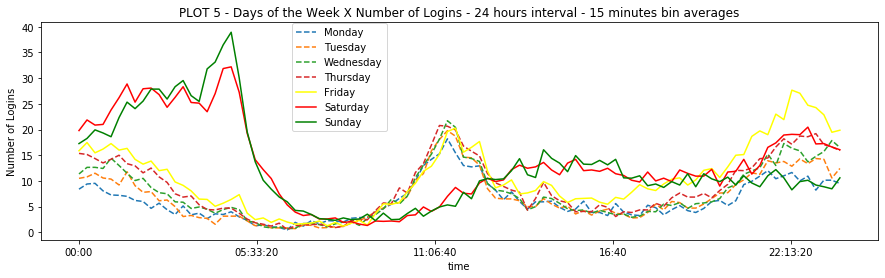

In [387]:
# Loop though the D.O.W, call the function toPlot for each D.O.W and keep the color code for consistensy
for (i,v) in enumerate(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]):    
    if(i<4):
        # Monday to Thursday
        plt.plot(toPlot(i)[0], toPlot(i)[1], label=v, linestyle='dashed')
    elif(i==4):
        # Friday
        plt.plot(toPlot(i)[0], toPlot(i)[1], label=v, color='yellow')
    elif(i==5):
        # Saturday
        plt.plot(toPlot(i)[0], toPlot(i)[1], label=v, color='red') 
    else:
        # Sunday
        plt.plot(toPlot(i)[0], toPlot(i)[1], label=v, color='green')
        
plt.title("PLOT 5 - Days of the Week X Number of Logins - 24 hours interval - 15 minutes bin averages")
plt.ylabel("Number of Logins")
plt.legend(loc=(0.30,0.5))
plt.show()


## PLOT 5 Analysis
- The highest peaks are likely to happen on Sundays at around 5 am. This explains why I found so many peaks on Sundays on PLOT 2, even though the demand is higher on Saturday, as seen on PLOT 3.
- Monday to Friday, from 12 am to 4 pm, the pattern for the number of logins is the same: moderate peak at 12 am, slowly fades away until 7 am, hits the daily peak at around 11 am, and slowly decreases until 4 pm. After 4 pm, Monday to Thursday show a slow increase until 12 am, when the cycle restarts. Friday, however, behaves like Weekend.
- Friday and Saturday after 5 pm behave similarly: demand increase until around 5 am the next day, where the biggest peaks are reached. After this time, the demand drops quickly reaching the daily valley at around 10 am. We can then see a small increase until around 5 pm, when the cycle restarts.
- Sunday after 5 pm behaves like a normal weekday.

# Conclusion - Part1
I was able to identify monthly, weekly, and daily patterns with the help of 5 plots. Hopefully, the sections of the report flow naturally and the reader understands that, from one plot analysis, questions are raised and other plots are needed.<br>
I used different strategies to conceive similar plots intentionally, just to explore different solutions.<br>
Let's head to part 2 of the challenge!